In [17]:
import sys
sys.path.insert(0, '/home/tomma/litebird/litebird_sim_clone/litebird_sim')
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt

In [18]:
nside = 512
mission_time_is_sec = 3600*24
instrument = "MFT"
channel = "M1-100"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [19]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [20]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [21]:
dets=[]
detquats=[]
for detname in channelinfo.detector_names[0:2]:
#for detname in channelinfo.detector_names:
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

In [22]:
len(dets)

2

In [23]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [24]:
Mbsparams = lbs.MbsParameters(make_cmb =True,
                              make_fg = False,
                              gaussian_smooth = True,
                              bandpass_int = False,
                              nside = nside,
                             )

mbs = lbs.Mbs(simulation=sim,
              parameters=Mbsparams,
              channel_list=channelinfo,
             )
maps = mbs.run_all()[0][channel]

[2021-11-24 11:13:20,264 INFO MPI#0000] generating and saving cmb simulations


***************** D
***************** D
***************** D


/home/tomma/.local/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211124.fits
  warnings.warn(f"Access data from {full_path}")


In [25]:
hwp_sys = lbs.HwpSys(sim)
hwp_sys.set_parameters(maps=maps,
                       integrate_in_band=False,
                       correct_in_solver=False,
                       built_map_on_the_fly=False,
                       nside=nside,
                      )

In [26]:
hwp_sys.fill_tod(obs,pointings,hwp_radpsec)
obs.tod *= 2.0 #

In [27]:
m = lbs.make_bin_map([obs],nside).T

/home/tomma/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/tomma/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/tomma/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been de

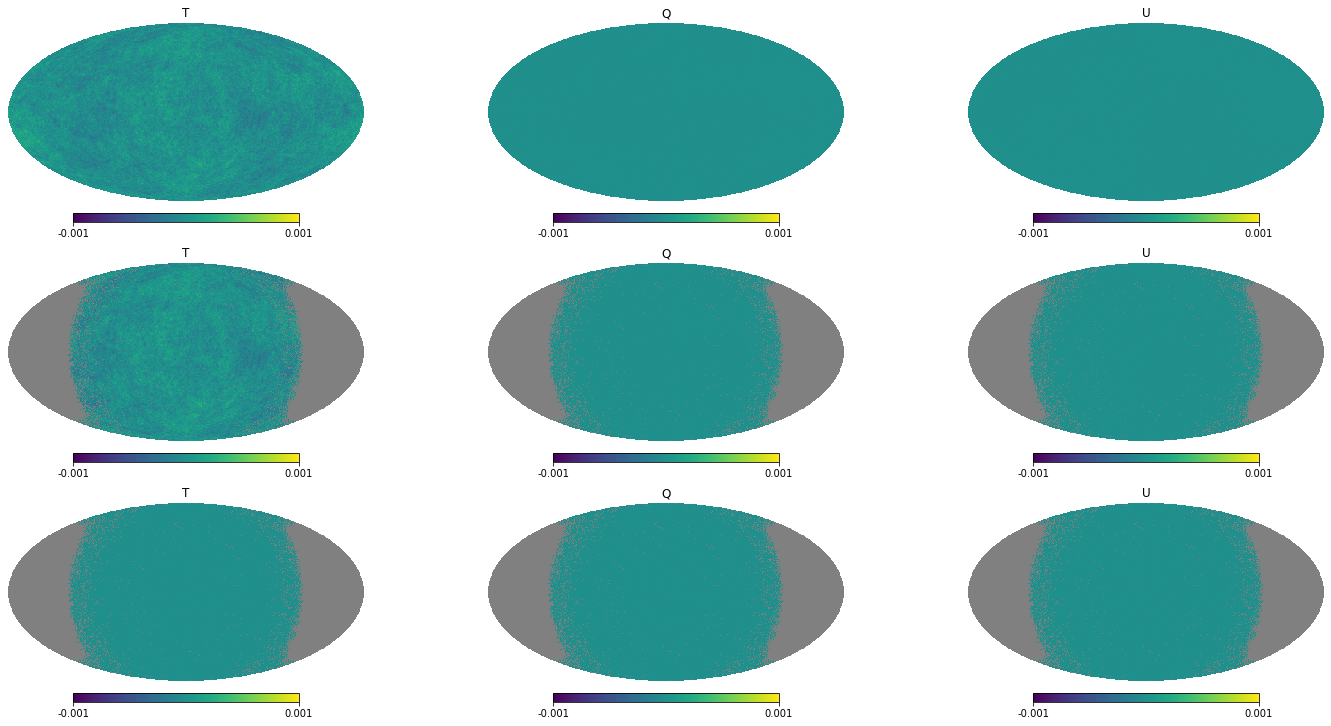

In [64]:
fig = plt.figure(figsize=(20,10))
hp.mollview(maps[0],sub=331,title='T',min=-1e-3,max=1e-3)
hp.mollview(maps[1],sub=332,title='Q',min=-1e-3,max=1e-3)
hp.mollview(maps[2],sub=333,title='U',min=-1e-3,max=1e-3)
hp.mollview(m[0],sub=334,title='T',min=-1e-3,max=1e-3)
hp.mollview(m[1],sub=335,title='Q',min=-1e-3,max=1e-3)
hp.mollview(m[2],sub=336,title='U',min=-1e-3,max=1e-3)
hp.mollview(m[0]-maps[0],sub=337,title='T',min=-1e-3,max=1e-3)
hp.mollview(m[1]-maps[1],sub=338,title='Q',min=-1e-3,max=1e-3)
hp.mollview(m[2]-maps[2],sub=339,title='U',min=-1e-3,max=1e-3)